## Travail pratique - 1 - IFT 3700

Travail présenté à 
Philippe Brouillard
Arnaud L'Heureux

Travail fait par 
BOUNOUAR Zakaria - 20026947
EID Alain - 20061065
STEENHAUT Sami - 20061630
VOICULESCU Eduard - 20078235

In [1]:
#!/usr/bin/env python
%matplotlib inline

# run pip install -U scikit-learn (if scikit-learn not installed)
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt  # run python3 -m pip install -U matplotlib
import numpy as np
import csv
import math
import copy

# load data_train in data_train
with open('mnist_train.csv') as data_train:
    csv_file = csv.reader(data_train)

    data_points = []

    for row in csv_file:
        data_points.append(row)

    # pop out first line, the "labels" of our columns
    data_points.pop(0)

# load data_test in data_test
with open('mnist_test.csv') as data_test:
    csv_file = csv.reader(data_test)

    data_points_test = []

    for row in csv_file:
        data_points_test.append(row)

    # pop out first line, the "labels" of our columns
    data_points_test.pop(0)

# Load les labels dans labels[]
labels = []

for row in data_points: 
    labels.append(row[0])  # La colonne des labels

x_train = []

for row in data_points:
    x_train.append(row[1:785])

# Load testing set in x_test
x_test = []
for row in data_points_test:
    x_test.append(row[1:785])

# Load labels in labels_test
labels_test = []
for row in data_points_test:
    labels_test.append(row[0])

In [2]:
q_train = copy.deepcopy(x_train[0:1000])
euclidean_train = euclidean_distances(q_train)

Dans la cellule suivante nous allons convertir toutes les données de q_train (qui sont de type string) en float.

In [3]:
for i in range(len(q_train)):
    for j in range(len(q_train[i])):
            q_train[i][j] = float(q_train[i][j])

**Notion de similarité**

Pour notre notion de similarité nous avons décidé de s’inspirer de la distance d’édition de Hamming. L’idée est de comparer les pixels correspondants de chaque images tout comme avec la distance euclidienne, mais au lieux de calculer la différence d’intensité et d’en faire une distance, nous vérifions simplement si les deux pixels sont de "la même couleur". Par couleur, on entend blanc ou noir/gris. En d’autre mots, la notion de similarité proposée représente le nombre de pixels qu’il faut changer (passer de blanc à noir/gris ou vice-versa) sur une image A pour obtenir l’image B.

Avant d’écrire un algorithme pour quantifier cette similarité il faut établir une limite d’intensité de gris à partir de laquelle on ne considère plus que le pixel est blanc. Nous avons remarqué que les pixels devenaient gris très rapidement et qu’autour de 50 on ne pouvait déjà plus considérer le pixel comme étant blanc. Après quelques tests et par consensus d’équipe, 40 fut choisi comme limite. Au-dessus de cette valeur le pixel est considéré gris/noir par notre mesure.

Cette distance d’édition se calcule de la manière suivante. Lorsqu’on compare une image A avec une image B, à chaque pixel correspondant sur les deux images on vérifie la valeur d’intensité. Si les deux valeurs sont en bas de 40 (les deux pixels correspondants sont blancs) ou les deux sont en haut de 40 (les deux sont noirs/gris) on considèrent que les deux pixels sont de la même couleur. Sinon, on considèrent qu’ils ne sont pas de la même couleur (un est blanc alors que l’autre est noir/gris) et la distance entre les deux images est incrémentée de 1.

Par conséquent, la distance minimale entre deux images est 0 ce qui signifie qu’elles sont identiques et la distance maximale est de 784 qui signifie que les deux images n’ont pas un seul pixel en commun.

Notre hypothèse est que cette notion de similarité devraient avoir à peu près la même performance que la distance euclidienne puisque toutes les deux se basent sur l’intensité des pixels. La différence est qu’avec notre méthode la mesure est plus souple puisqu’elle permet théoriquement à deux images du même chiffre qui ont des intensités de gris différentes dans certains pixels noirs d’avoir une distance nulle (de 0).

Ci-dessous, nous calculons notre notion de similarité.

In [4]:
edition_train = []
for i in range(len(q_train)):
    row = []
    for j in range(len(q_train)):
        row_x = q_train[i]
        row_y = q_train[j]
        total_dist = 0
        for k in range(len(row_x)):
            # Itensité des pixels correspondants de chaque image
            pixel_value_x = row_x[k]
            pixel_value_y = row_y[k]
            
            # si les pixels sont blancs ou les pixels sont noirs/gris
            if (pixel_value_x < 40 and pixel_value_y < 40) or (pixel_value_x >= 40 and pixel_value_y >= 40): 
                total_dist += 0
            else:  # ne sont pas de la meme couleur
                total_dist += 1
        
        row.append(total_dist)
    edition_train.append(row)

**k-medoïde**

Dans la section ci-dessous, nous allons appliquons la méthode k-Médoïde sur une partie de nos données.
En effet, il serait vraiment plus pratique et surtout précis d'utiliser toutes nos données dans x_train, 
mais jouer avec 60 000 données impliqueraient d'avoir des Memory Errors asssurées. 
On va donc ce créer un nouveau tableau (Q_train) contenant les 1000 premières données de x_train et 
nous placerons leurs labels dans un nouveau tableau (L_train). <br><br>
Donc pour commencer, nous allons créer deux matrices de distance.
<br> La première, appelée matrice_distance_euclidienne, sera la matrice de distances euclidiennes des données de Q_train.
<br> La deuxième, appelée matrice_our_distance, sera la matrice de distances calculés avec notre mesure de similarité.

Notre jeu de données réduit !

In [5]:
Q_train = np.array(copy.deepcopy(x_train[0:1000])).astype(np.float64)
L_train = np.array(copy.deepcopy(labels[0:1000])).astype(np.float64)

matrice_distance_euclidienne = euclidean_distances(Q_train)
matrice_our_distance = np.array(copy.deepcopy(edition_train)).astype(np.float64)

Nous allons maintenant importer les librairies nécessaires.

In [6]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedoids import kmedoids  # run pip install pyclustering

Maintenant que nous avons nos matrices de distances, on peut passer à l'application de K-Médoïde. <br>
Tout d'abord, il faut choisir la valeur de l'hyperparamêtre k. Nous allons utiliser la méthode vue en démo, soit celle du score silhouette. (fortement inspiré de la démo 2)

Text(0.5, 1.0, 'Score silhouette en fonction de k')

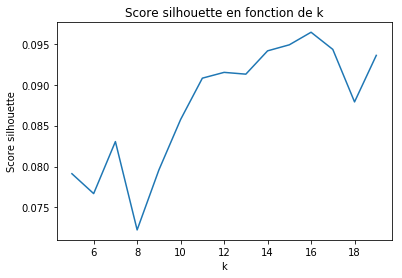

In [28]:
scores = []
k_range = range(5,20)
for k in k_range:
    y_pred = KMeans(n_clusters=k).fit_predict(Q_train)
    scores.append(silhouette_score(Q_train, y_pred))
    
    
plt.plot(k_range, scores)
plt.xlabel('k')
plt.ylabel('Score silhouette')
plt.title('Score silhouette en fonction de k')

**Prenez note**: Si vous relancez la cellule ci-dessus, il se peut que le nombre de cluster *optimal* change.<br>
On obtient un hyperparamêtre k qui vaut 16. C'est intriguant, car intuitivement on aurait pu penser que k aurait valu 10,
car il y a 10 classes. Mais en fait, il est possible que notre méthode de partitionnement aille pris en compte les graphies
différentes de certains chiffres, ce qui fait en sorte, que le chiffre 7, par exemple, pourrait être représenté par plus d'un cluster.<br><br>
Maintenant que nous avons notre k, nous pouvons implémenter notre méthode k-Médoïde. Nous allons la faire pour la version euclidienne ainsi que pour la version de notre propre mesure de distance.

*Version Euclidienne*

In [29]:
initial_medoids_euclidienne = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# ici, nous donnons directement notre matrice de distances euclidiennes
kmedoids_instance_euclidienne = kmedoids(matrice_distance_euclidienne, initial_medoids_euclidienne, data_type='distance_matrix')
kmedoids_instance_euclidienne.process()
clusters_euclidienne = kmedoids_instance_euclidienne.get_clusters()
medoids_euclidienne = kmedoids_instance_euclidienne.get_medoids()

*Version our_distance*

In [30]:
initial_medoids_our_distance = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# ici, nous donnons directement notre matrice_our_distance
kmedoids_instance_our_distance = kmedoids(matrice_our_distance, initial_medoids_our_distance, data_type='distance_matrix')
kmedoids_instance_our_distance.process()
clusters_our_distance = kmedoids_instance_our_distance.get_clusters()
medoids_our_distance = kmedoids_instance_our_distance.get_medoids()

Une fois fait, on peut visualiser quel est la valeur de nos 16 clusters en allant chercher leur label.<br><br>
Pour voir le partionnement, on propose d'allez selectionner le label le plus récurent de chaque section, pour savoir si les données sont bien réparties dans chaque zone crée par les centroides.

*Version Euclidienne* -> Centroïde

In [31]:

#Tout d'abord, il faut créer une liste, qui contiendra toutes les labels selon leur cluster associé
labels_by_clusters = []
for i in range(len(clusters_euclidienne)):
    labels_by_row= []
    for j in range(len(clusters_euclidienne[i])):
        labels_by_row.append(L_train[clusters_euclidienne[i][j]])
    labels_by_clusters.append(labels_by_row)
    
#Puis, créer une liste qui contiendra le label le plus récurent par cluster
most_recurent_label = []
counts = []
for i in range(len(labels_by_clusters)):
    counts.append(np.bincount(labels_by_clusters[i]))
    most_recurent_label.append(np.argmax(counts[i]))    


for i in range(len(most_recurent_label)):
    print('Centroïde "',L_train[medoids_euclidienne[i]],'" :: label le plus recurrent ',most_recurent_label[i], ':: et est présent à ',round(max(counts[i])*100/len(labels_by_clusters[i]),2),'%')

Centroïde " 5.0 " :: label le plus recurrent  5 :: et est présent à  60.0 %
Centroïde " 0.0 " :: label le plus recurrent  0 :: et est présent à  94.74 %
Centroïde " 4.0 " :: label le plus recurrent  4 :: et est présent à  53.85 %
Centroïde " 1.0 " :: label le plus recurrent  1 :: et est présent à  55.05 %
Centroïde " 9.0 " :: label le plus recurrent  9 :: et est présent à  44.55 %
Centroïde " 2.0 " :: label le plus recurrent  2 :: et est présent à  69.64 %
Centroïde " 1.0 " :: label le plus recurrent  1 :: et est présent à  51.52 %
Centroïde " 3.0 " :: label le plus recurrent  3 :: et est présent à  56.0 %
Centroïde " 1.0 " :: label le plus recurrent  1 :: et est présent à  18.03 %
Centroïde " 4.0 " :: label le plus recurrent  4 :: et est présent à  76.67 %
Centroïde " 3.0 " :: label le plus recurrent  3 :: et est présent à  66.67 %
Centroïde " 5.0 " :: label le plus recurrent  5 :: et est présent à  55.56 %
Centroïde " 3.0 " :: label le plus recurrent  5 :: et est présent à  42.5 %
Ce

C'est le temps de tester avec notre distance. Nous allons répéter les mêmes étapes, mais avec les variables our_distance.

Version our_distance -> Centroïde

In [32]:

#Tout d'abord, il faut créer une liste, qui contiendra toutes les labels selon leur cluster associé
labels_by_clusters_od = [] #od pour our_distance
for i in range(len(clusters_our_distance)):
    labels_by_row_od= []
    for j in range(len(clusters_our_distance[i])):
        labels_by_row_od.append(L_train[clusters_our_distance[i][j]])
    labels_by_clusters_od.append(labels_by_row_od)
    
#Puis, créer une liste qui contiendra le label le plus récurent par cluster
most_recurent_label_od = []
counts_od = []
for i in range(len(labels_by_clusters_od)):
    counts_od.append(np.bincount(labels_by_clusters[i]))
    most_recurent_label_od.append(np.argmax(counts[i]))    

for i in range(len(most_recurent_label_od)):
    print('Centroïde "',L_train[medoids_our_distance[i]],'" :: label le plus récurrent ',most_recurent_label_od[i], ':: et est présent à ',round(max(counts_od[i])*100/len(labels_by_clusters_od[i]),2),'%')

Centroïde " 5.0 " :: label le plus récurrent  5 :: et est présent à  93.1 %
Centroïde " 0.0 " :: label le plus récurrent  0 :: et est présent à  93.51 %
Centroïde " 4.0 " :: label le plus récurrent  4 :: et est présent à  59.57 %
Centroïde " 1.0 " :: label le plus récurrent  1 :: et est présent à  55.56 %
Centroïde " 9.0 " :: label le plus récurrent  9 :: et est présent à  50.0 %
Centroïde " 2.0 " :: label le plus récurrent  2 :: et est présent à  59.09 %
Centroïde " 1.0 " :: label le plus récurrent  1 :: et est présent à  34.0 %
Centroïde " 3.0 " :: label le plus récurrent  3 :: et est présent à  66.67 %
Centroïde " 1.0 " :: label le plus récurrent  1 :: et est présent à  17.19 %
Centroïde " 4.0 " :: label le plus récurrent  4 :: et est présent à  79.31 %
Centroïde " 3.0 " :: label le plus récurrent  3 :: et est présent à  37.29 %
Centroïde " 5.0 " :: label le plus récurrent  5 :: et est présent à  71.43 %
Centroïde " 3.0 " :: label le plus récurrent  5 :: et est présent à  37.78 %
Ce

Juste pour avoir un chiffre qui représente la précision global de notre model, on fait la moyenne de chaque précision.

In [33]:
accuracy = 0
for i in range(len(most_recurent_label)):
    accuracy += round(max(counts[i])*100/len(labels_by_clusters[i]),2)
accuracy = accuracy/16

accuracy_od = 0
for i in range(len(most_recurent_label_od)):
    accuracy_od += round(max(counts_od[i])*100/len(labels_by_clusters_od[i]),2)
accuracy_od = accuracy_od/16

print('La précision du k-Médoïde avec distance euclidienne',round(accuracy,2),'%')
print('La précision du k-Médoïde avec notre mesure de similarité',round(accuracy_od,2),'%')

La précision du k-Médoïde avec distance euclidienne 58.18 %
La précision du k-Médoïde avec notre mesure de similarité 59.84 %


Avec les résultats que nous obtenons, on peut conclure qu'avec le nombre de données limité, le model avec notre calcul de distance est un peu plus performant qu'avec la distance euclidienne. Bien évidemment, tel est le cas puisque nous avons utilisé le même jeu de données. Si nous utilisons un jeu de donnée différent, les résultats peuvent s'avérer différent. 
Certainement, avec plus de donnée nous aurions une meilleure comparaison et surtout une meilleure précision de nos models.

**Partition Binaire**

### Hierarchical Clustering (Binary Partition)

Dans la section ci-dessous, nous allons appliquer l'algorithme de partition binaire, s'intitulant "Hierarchical Clustering" en anglais. Il y a deux types de "Hierarchical Clustering": il y a le agglomerative et le decisive. Dans notre cas, nous allons nous préoccuper du agglomerative clustering. De plus, l'algorithme de "Hierarchical Clustering" a pour but de "prédire" des données non **étiquettés.**<br>
Pour commencer, nous allons importer Agglomerative Clustering de sklearn.cluster puisque cette dernière nous aidera à appliquer l'algorithme. <br>
Dans l'algorithme de partition binaire, il y a principalement 4 méthodes pour mesurer la distance entre 2 clusters: <br>
* Measure the distance between the closes points of two clusters.
* Measure the distance between the farthest points of two clusters.
* Measure the distance between the centroids of two clusters.
* Measure the distance between all possible combination of points between the two clusters and take the mean.
<br>
(Source: https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/)

In [15]:
from sklearn.cluster import AgglomerativeClustering

La prochaine étape est de bien préparer nos données. Pour des fins d'utilié, de représentation et pour eviter un Memory Error, nous allons utiliser les 1000 premières données. Nous allons également convertir nos 1000 premières données en array de NumPy de type np.float64.

In [16]:
agglomerative_clustering_train = np.array(copy.deepcopy(x_train[0:1000])).astype(np.float64)
agglomerative_clustering_labels = np.array(copy.deepcopy(labels[0:1000])).astype(np.float64)

Imprimons la première donnée de notre agglomerative_clustering_train pour visualiser notre NumPy Array.

In [17]:
print(agglomerative_clustering_train[0])

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
 253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.   0.   0.   0.
   0. 

La prochaine étape est de créer un object hirarchical_clustering en utilisant le constructeur AgglomerativeClustering. Nous allons également appeler fit_predict pour prédire les clusters que les points prendrons part. La méthode fit_predict retournera le cluster que chaque point prend part. Nous utilisons la distance euclidienne.<br>
**Prenez note**: Nous utilisons le linkage comme étant ward puisque ce dernier minimise la variance des clusters à fusionner.

In [18]:
# The Treshold is that every cluster's dissimilarity (inside and amonsgt them) will always be smaller or equal to that cluster
# Here our thresh hold is 10 as the number of classes in mnist data set (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

hierarchical_clustering = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward') 
y_hierarchical_clustering = hierarchical_clustering.fit_predict(agglomerative_clustering_train)  

Imprimons notre matrice avec les points appartenant à dites cluster.

In [19]:
print(hierarchical_clustering.labels_)

[4 0 1 3 1 6 9 8 9 1 4 2 4 5 9 7 0 2 4 2 1 0 2 3 4 4 1 8 0 2 1 2 4 2 0 2 5
 0 1 5 9 4 1 3 4 1 4 2 4 4 4 0 1 2 1 2 0 1 1 3 1 2 5 0 1 2 5 3 0 0 4 2 9 5
 4 0 4 3 3 2 4 0 0 5 1 2 4 1 0 1 5 7 1 5 2 0 1 2 4 3 4 1 9 7 9 3 4 8 0 1 1
 4 9 3 0 1 1 4 0 0 0 0 4 7 9 4 4 1 9 5 4 1 4 1 1 8 4 3 4 1 3 2 1 4 4 2 2 5
 1 4 1 5 9 2 1 5 0 8 1 4 1 4 1 2 1 5 1 1 3 0 1 4 1 2 9 2 1 3 0 4 3 4 4 1 9
 7 4 4 4 4 4 2 0 7 1 2 1 2 4 4 9 3 2 4 5 3 0 4 9 0 0 9 1 6 1 8 0 1 4 2 6 5
 1 7 1 2 1 1 1 0 7 9 4 6 0 8 2 1 5 2 4 1 8 7 0 2 0 1 9 0 1 9 4 6 4 8 4 1 1
 2 1 5 4 7 1 2 4 1 1 3 9 1 1 2 4 1 9 6 4 8 1 8 1 0 4 1 5 2 1 1 3 8 1 0 1 2
 0 1 4 5 4 7 5 0 1 7 0 7 6 3 9 5 4 1 1 3 4 6 4 1 0 8 1 1 1 6 0 8 4 1 4 5 4
 4 1 2 1 7 1 6 1 8 1 2 1 3 1 6 4 7 1 3 4 7 1 3 4 3 9 0 4 8 1 1 1 6 9 5 4 1
 9 7 1 1 1 6 4 7 4 1 1 6 9 1 1 6 4 7 4 1 4 6 4 2 4 5 4 3 9 0 4 5 1 2 4 8 9
 2 9 1 4 7 1 1 5 2 3 2 2 1 1 5 1 1 1 4 1 0 1 0 4 5 0 8 1 0 1 2 1 2 0 1 1 3
 9 2 1 3 6 5 9 0 0 0 9 3 4 6 0 4 1 1 0 2 0 5 9 0 1 2 4 2 4 0 4 3 4 6 1 8 4
 1 1 0 9 2 4 2 4 0 4 3 3 

Maintenant, visualisons notre graphe avec nos données.

In [21]:
y_hierarchical_clustering = hierarchical_clustering.labels_
# print(len(cluster.labels_)) It's the same as our q_train array
labels_hc = labels[0:1000]

# The result will be a vector of 1000 entries and were every entry belongs to as certain cluster
miss_calculations = 0
for i in range(len(y_hierarchical_clustering)):
    if not y_hierarchical_clustering[i] == int(agglomerative_clustering_labels[i]):
        miss_calculations += 1

print(f"If we only assumed that the clusters were the labels to take, by simply using the data, we would misplace " 
      + str(miss_calculations) + " out of " + str(1000) + " labels.")

If we only assumed that the clusters were the labels to take, by simply using the data, we would misplace 859 out of 1000 labels.


Nous allons maintenant procéder à utiliser le data set silhouette.csv de la démo 2 puisque l'algorithme échou lamentablement.

#### Hierarchical Clustering  (Binary Partition) avec silhouette data set
Dans la démo 2, nous nous sommes fait présentés le data set silhouette.csv. Ce dernier est en effet les 5000 premières données de MNIST mais ayant subit une réduction de dimensionnalité.<br>
La première étape est de charger les données dans un tableau.

In [34]:
with open('silhouette.csv') as silhouette_data_train:
    silhouette_data_train = np.loadtxt('silhouette.csv')

Par la suite, puisqu'il n'y a pas de labels dans silhouette.csv, nous allons utiliser les 1000 premièrs étiquettes de notre mnist_train.csv.<br>
**Prenez note**: Nous utilisons seulement les 1000 premières données question de ne pas recontrer Memory Error.

In [35]:
silhouette_labels = copy.deepcopy(labels[0:1000])
silhouette_data_train = copy.deepcopy(silhouette_data_train[0:1000])

Ci-dessous, nous avons simplement représenté nos 1000 premières données de silhouette_data_train dans un graphique. Puisque nous avons charger un data set de 2 dimensions, il se prouve facile de représenter les données dans un graphe conventinnel x,y.

(La cellule ci-dessous est fortement inspirée de la démo 2)

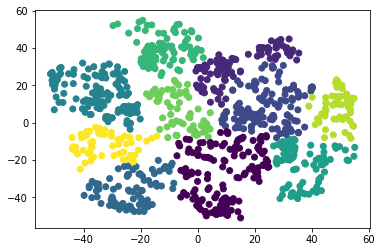

In [36]:
y_pred = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward').fit_predict(silhouette_data_train)
plt.scatter(silhouette_data_train[:,0], silhouette_data_train[:,1], c=y_pred)

Maintenant, nous allons utiliser la librairie SciPy pour créer un dendrogramme.<br>
Il est utile de créer un dendogramme pour savoir combien de cluster sont en réalité nécessaire. Bien que nous sommes familier avec MNIST et que nous sachions qu'il y aura 10 clusters, il faut tout de même le représenter en dendrogramme. Pour une utilisation future avec des données qui ne sont pas familières, il se vaut utile.<br>
Comme d'habitude, la première étape est de charger les librairies nécessaire.

In [37]:
from scipy.cluster.hierarchy import dendrogram, linkage
import sklearn.metrics as sm

Maintenant que nous avons nos imports, nous allons créer notre dendrogramme pour trouver le bon "threshold".<br>
**Threshold**: Le threshold se réfère à la dissimilarité entre les clusters. Ça va toujours être plus petit ou égal au nomtre de clusters.

In [38]:
for i, value in enumerate(silhouette_data_train): 
    for j, value in enumerate(silhouette_data_train[i]):
        silhouette_data_train[i][j] = float(silhouette_data_train[i][j])

En premier temps, nous allons créer le linkage entre nos données et les 'ward'.

In [39]:
Z = linkage(silhouette_data_train, 'ward')

Créeons le dendrogramme maintenant!<br>
Pour de fin de visualisation et pour rendre le dendrogramme plus conviviable, nous allons créer un *Truncated Hierarchical Clustering Dendrogram*.<br>
De plus, comme mentionnée plus haut, nous devons mettre un threshold à un certain niveau pour savoir exactement le nombre de clusters à mettre. Pour le threshold, il faut prendre la distance verticale la plus haute sans couper une ligne horizontale. La distance est aux alentours de y = 200. Cela va créer 10 clusters.

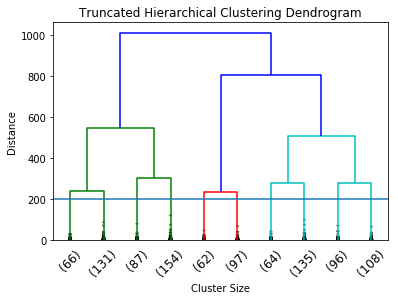

In [40]:
dendrogram(Z, truncate_mode='lastp', p=10, leaf_rotation=45., leaf_font_size=12., show_contracted=True)
plt.title("Truncated Hierarchical Clustering Dendrogram")
plt.xlabel('Cluster Size')
plt.ylabel('Distance')

plt.axhline(y=200)

plt.show()

Exactement ce que nous avions estimé plus haut, nous devons utiliser 10 clusters.

Convertir les labels en int pour pouvoir utiliser accurary_score venant de sklearn.metrics.

In [41]:
for i in range(len(silhouette_labels)):
    silhouette_labels[i] = int(silhouette_labels[i])

In [81]:
Hclustering = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
Hclustering.fit(silhouette_data_train)

print("Le score de notre Hierarchical Clustering avec la distance euclidienne est de : " 
     + str(sm.accuracy_score(silhouette_labels, Hclustering.labels_) * 100)
     + " %.")

Le score de notre Hierarchical Clustering avec la distance euclidienne est de : 23.1 %.


Comparons maintenant avec plusieurs différents linkage types.

In [43]:
# linkage -> complete
Hclustering = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='complete')
Hclustering.fit(silhouette_data_train)

print(f"Accuracy score for complete linkage : {str(sm.accuracy_score(silhouette_labels, Hclustering.labels_) * 100)}  %.")

# linkage -> average 
Hclustering = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='average')
Hclustering.fit(silhouette_data_train)

print(f"Accuracy score for average linkage : {str(sm.accuracy_score(silhouette_labels, Hclustering.labels_) * 100)}  %.")

# linkage -> single
Hclustering = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='single')
Hclustering.fit(silhouette_data_train)

print(f"Accuracy score for single linkage : {str(sm.accuracy_score(silhouette_labels, Hclustering.labels_) * 100)} %.")

Accuracy score for complete linkage : 13.8  %.
Accuracy score for average linkage : 5.8999999999999995  %.
Accuracy score for single linkage : 5.1 %.


Procédons maintenant à appliquer l'algorithme de *Hierarchical Clustering* à notre mesure de similarité. En premier temps, charger les données (nous faisions simplement un deepcopy de nos données plus haut).

In [44]:
edition_hierarchical_clustering_data_train = copy.deepcopy(edition_train)
edition_hierarchical_clustering_data_label = copy.deepcopy(labels[0:1000])
edition_hierarchical_clustering_data_train = np.array(edition_hierarchical_clustering_data_train).astype(np.float64)
edition_hierarchical_clustering_data_label = np.array(edition_hierarchical_clustering_data_label).astype(np.float64)

Comparons maintenant avec plusieurs différents linkage types.

In [45]:
# linkage -> complete
edition_hirarchical_clustering_classifier = AgglomerativeClustering(n_clusters=10, affinity='precomputed', linkage='complete')
edition_hirarchical_clustering_classifier.fit(edition_hierarchical_clustering_data_train)

print(f"Accuracy score for complete linkage (with our notion of similarity) : {str(sm.accuracy_score(edition_hierarchical_clustering_data_label, edition_hirarchical_clustering_classifier.labels_) * 100)}  %.")

# linkage -> average
edition_hirarchical_clustering_classifier = AgglomerativeClustering(n_clusters=10, affinity='precomputed', linkage='average')
edition_hirarchical_clustering_classifier.fit(edition_hierarchical_clustering_data_train)

print(f"Accuracy score for average linkage (with our notion of similarity) : {str(sm.accuracy_score(edition_hierarchical_clustering_data_label, edition_hirarchical_clustering_classifier.labels_) * 100)}  %.")

# linkage -> single
edition_hirarchical_clustering_classifier = AgglomerativeClustering(n_clusters=10, affinity='precomputed', linkage='single')
edition_hirarchical_clustering_classifier.fit(edition_hierarchical_clustering_data_train)

print(f"Accuracy score for single linkage (with our notion of similarity) : {str(sm.accuracy_score(edition_hierarchical_clustering_data_label, edition_hirarchical_clustering_classifier.labels_) * 100)}  %.")


Accuracy score for complete linkage (with our notion of similarity) : 3.6999999999999997  %.
Accuracy score for average linkage (with our notion of similarity) : 10.7  %.
Accuracy score for single linkage (with our notion of similarity) : 9.8  %.


In [46]:
# TODO -> conclusion

**PCoA**

Comme d'habitude, nous devons importer la librairie nécessaire.

In [47]:
from sklearn.manifold import MDS

PCoA sur notre distance euclidienne calculée précédement.

In [48]:
mds = MDS(dissimilarity='precomputed')
positions_euclidean = mds.fit(euclidean_train)

PCoA sur notre distance d'édition.

In [49]:
mds_edition = MDS(dissimilarity='precomputed')
positions_custom = mds_edition.fit(edition_train)

PCoA sur la distance euclidienne calculée par la librairie.

In [50]:
mds_euclidean = MDS()
position_euclidiean_mds = mds_euclidean.fit(q_train)

Extraction des composantes pour tracer les figures.

In [51]:
positions_e = positions_euclidean.embedding_
positions_c = positions_custom.embedding_
position_e_mds = position_euclidiean_mds.embedding_

Figure 1 - Résultats avec la distance d'édition

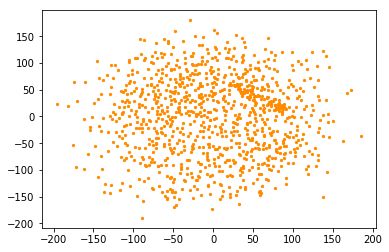

In [52]:
fig = plt.figure(1)
plt.scatter(positions_c[:, 0], positions_c[:, 1], color='darkorange', s=5, label='Distance Edition Personalisée')
plt.show()

Figure 2 - Résultats avec la distance euclidienne

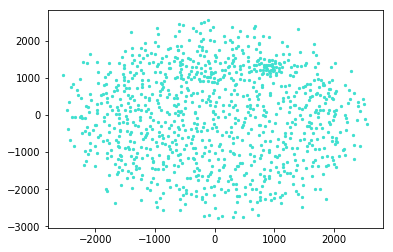

In [53]:
fig = plt.figure(4)
plt.scatter(positions_e[:, 0], positions_e[:, 1], color='turquoise', s=5, label='Distance Euclidienne')
plt.show()

Figure 3 - Résultats avec la distance euclidienne de la librairie

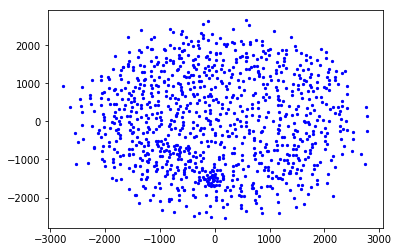

In [54]:
fig = plt.figure(5)
plt.scatter(position_e_mds[:, 0], position_e_mds[:, 1], color='blue', s=5, label='Distance Euclidienne MDS')
plt.show()

Les résultats sont malheureusement décevant pour PCoA avec une distance euclidienne tout comme avec notre notion de similarité. Presque aucun regroupement n’est obtenu. Même en essayant avec un échantillon de données plus grand (4000, il est difficile d’aller plus haut avec le hardware limité de nos machines) les résultats sont les mêmes.

Il est difficile de comparer la performance des deux méthodes avec les résultats actuels, tout ce que nous pouvons en conclure c’est que toutes les deux offrent un faible regroupement. Avec un échantillon de données plus grand il serait peut-être possible d’obtenir des regroupements (clusters) plus satisfaisants, mais pour le moment les deux distances (euclidienne et notre notion de similarité) offrent des résultats tout aussi faibles.

**IsoMap**

Comme d'habitude, nous devons importer la librairie nécessaire.

In [55]:
from sklearn.manifold import Isomap

On commence par appliquer la méthode Isomap sur la distance euclidienne. La librairie utilisée calcule elle-même la matrice de distance euclidienne (tout comme pour PCoA).

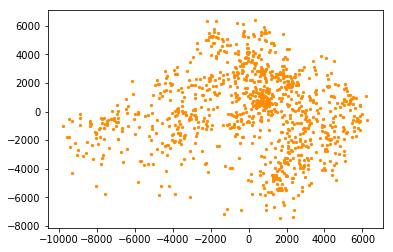

In [58]:
isomap_euclidean = Isomap(n_neighbors=5, n_components=2)
isomap_euclidean_result = isomap_euclidean.fit(q_train)
isomap_euclidean_positions = isomap_euclidean_result.embedding_

fig = plt.figure(1)
plt.scatter(isomap_euclidean_positions[:, 0], isomap_euclidean_positions[:, 1], color='darkorange', s=5, label='Isomap Distance Euclidienne')
plt.show()

La librairie utilisée pour appliquer l'algorithme IsoMap ne nous permet pas d'utiliser une matrice de dissimilarité "precomputed" comme pour toutes les autres méthodes. Par conséquent nous n'avons malheureusement pas réussi a utiliser notre propre notion de similarité sur cet algorithme.

**KNN**

Steps taken for KNN algorithm:
1. Choose the number K of neighbors.
2. Take the K nearest neighbors of the new data point, according to the Euclidean distance.
3. Among those K neighbors, count the number of data points in each category.
4. Assign the new data point to the category where you counted the most neightbors.

Comme d'habitude, nous devons importer les librairies nécessaires. Nous importons KNeighborsClassifier de sklearn pour créer notre classifieur et confusion_matrix (vous verrez pourquoi ;))<br>
Nous importons également la librairie copy pour faire un deepcopy. On ne veut pas juste pointer au même objet.

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

En premier lieu, nous allons utiliser le jeu de donnée silhouette pour notre modèle K-NN. Rappelons nous que silhouette.csv
est en fait les 5000 premières données de MNIST ayant subi une réduction de dimensionnalité.

In [60]:
knn_silhouette_train = copy.deepcopy(silhouette_data_train)
knn_silhouette_train_labels = copy.deepcopy(silhouette_labels)

Nous allons maintenant procéder à créer notre classifeur de K-NN. <br> (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) <br>
En regardant, la documentation de sklearn.neighbors.KNeighborsClassifier nous pouvons voir que le constructeur KNeighborsClassifer prend plusieurs arguments en entrée. Les plus importants sont n_neighbors (le nombre de voisins), p et metric (lorsque metric prend la valeur de 'minkowski', si p=1 le constructeur utilisera la mesure de similarité Manhattan et lors que p=2 le constructeur utilisera la mesure de similarité Euclidean).

In [61]:
silhouette_classifier = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
silhouette_classifier.fit(knn_silhouette_train, knn_silhouette_train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [82]:
print("Le score de notre silhouette classifeur avec la distance euclidienne est de : " 
      + str(silhouette_classifier.score(knn_silhouette_train, knn_silhouette_train_labels) * 100) 
      + " %.")


Le score de notre silhouette classifeur avec la distance euclidienne est de : 96.7 %.


Même si nous avons un excellent résultant (96.7%), essayons maintenant de trouver un **k** permettant d'améliorer ce résultat. 

In [63]:
score_train = []
for k in np.arange(1, 50):
    clf = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
    clf.fit(knn_silhouette_train, knn_silhouette_train_labels)
    score_train.append(clf.score(knn_silhouette_train, knn_silhouette_train_labels))

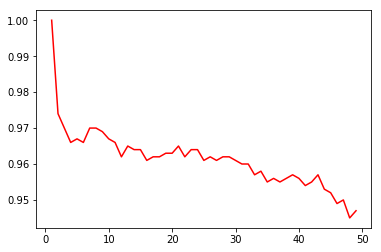

In [64]:
plt.plot(np.arange(1, 50), score_train, color='red')

Comme on peut voir, K-NN est très performant avec le jeu de donnée silhouette.csv. Plus on augmente le nombre de voisins *k*, la performance de l'algorithme diminue tranquillement. Il reste toutefois, un taux de succès à plus de 90 %.

Malheureusement, nous avons beau avoir un aussi bon résultat, il n'y a pas de manière pour tester notre classifieur de silhouette, puisque nous avons seulement un training set et non un test set. De plus nous ne pouvons pas utiliser le test set de MNIST_test.csv puisque ce ne sont pas les mêmes dimensions de données.

Nous devons prendre un autre chemin !

Pour palier à noter classifieur plus haut, nous allons créer un classifieur avec les données de MNIST_train.csv. Nous commençons par charger le jeu de données mnist_train.csv dans une nouvelle variable. Comme d'habitude, nous allons seulement utiliser les 1000 premières données question d'éviter un Memory Error. <br>
**Prenez note**: Nous convertissons nos données d'entrainements et les labels respectifs à des NumPy array de type float64. 

In [70]:
knn_mnist_data_train = copy.deepcopy(x_train[0:1000])
knn_mnist_data_labels = copy.deepcopy(labels[0:1000])
knn_mnist_data_train = np.array(knn_mnist_data_train).astype(np.float64)
knn_mnist_data_labels = np.array(knn_mnist_data_labels).astype(np.float64)

Procédons de manière similaire à créer notre classifieur en utilisant le data set MNIST_train.csv.

In [71]:
mnist_classifier = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
mnist_classifier.fit(knn_mnist_data_train, knn_mnist_data_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [83]:
print("Le score de notre K-NN classifeur avec la distance euclidienne est de : " 
      + str(mnist_classifier.score(knn_mnist_data_train, knn_mnist_data_labels) * 100)
      + " %.")

Le score de notre K-NN classifeur avec la distance euclidienne est de : 90.8 %.


Même si nous avons un bon résultant (90.8%), essayons maintenant de trouver un **k** permettant d'améliorer ce résultat. 

In [73]:
score_train = []
for k in np.arange(1, 50):
    clf = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
    clf.fit(knn_mnist_data_train, knn_mnist_data_labels)
    score_train.append(clf.score(knn_mnist_data_train, knn_mnist_data_labels))

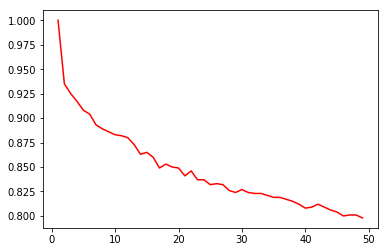

In [69]:
plt.plot(np.arange(1, 50), score_train, color='red')

On peut voir que l'algorithme K-NN est performant lorsque le nombre de voisins n'est pas trop grand. Bien évidemment, il n'y a pas de chiffre magique (nos sommes en statistics, alors tout dépend du use case), mais on peut toutefois faire un hypothèse qu'un k de 5 est un "bon" k.

Maintenant, testons notre classifieur avec des données de tests!

In [76]:
knn_mnist_data_test = copy.deepcopy(x_test[0:150])
knn_mnist_data_labels_test = copy.deepcopy(labels_test[0:150])
knn_mnist_data_test = np.array(knn_mnist_data_test).astype(np.float64)
knn_mnist_data_labels_test = np.array(knn_mnist_data_labels_test).astype(np.float64)

In [77]:
print("Le score de notre K-NN classifeur (avec les données test) est de : " 
      + str(mnist_classifier.score(knn_mnist_data_test, knn_mnist_data_labels_test) * 100)
      + " %.")

Le score de notre K-NN classifeur (avec les données test) est de : 88.0 %.


En classe nous avons appris qu'en général nous devons entrainer avec 85% de nos données et de tester avec 15%. Ici nous testons donc notre algorithme avec 15% de données.<br>
En comparaison des données d'entrainement et les données de test, nous passons de 90.8 % à 88.0 %. Il y a une certaine "perte" de performance. Mais avec plus d'entrainement on pourrait avoir de meilleurs résultats !

**KNN (Avec notre mesure de similarité)**

Nous allons appliquer les mêmes étapes que celles dénotées plus haut. 

In [78]:
edition_data_train = copy.deepcopy(edition_train)
edition_data_labels = copy.deepcopy(labels[0:1000])
edition_data_train = np.array(edition_data_train).astype(np.float64)
edition_data_labels = np.array(edition_data_labels).astype(np.float64)

In [79]:
edition_classifier = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
edition_classifier.fit(edition_data_train, edition_data_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='precomputed',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [80]:
print("Le score de notre K-NN classifeur (avec notre mesure de similarité) est de : " 
      + str(edition_classifier.score(edition_data_train, edition_data_labels) * 100)
      + " %.")

Le score de notre K-NN classifeur (avec notre mesure de similarité) est de : 90.4 %.


En conclusion, nous avons pas eu une amélioration comparativement à la méthode de similarité d'euclidienne. Comme vous pouvez voir, le classifieur de mnist_classifier nous donne un taux de succès de 90.8 % et notre classifieur de edition_classifier nous donne un taux de succès de 90.4%. Comme de fait, notre mesure de similarité n'est pas plus performante, en fait elle est 0.4% moins performante avec le même data set. On ne peut pas conclure directement que notre mesure n'est pas moins performante. Idéalement il faudrait utiliser un data set plus gros et cela nous permettra d'avoir un meilleur jeu d'entrainement. 

## Conclusion

En somme, notre mesure de similarité n’apporte pas grand choses par rapport à la distance euclidienne. <br><br>
En ce qui concerne l'algorithme k-médoïde, la précision avec la distance euclidienne est de 58.18 % et la précision avec notre mesure de similarité est de 59.84 %. On peut voir qu'il y a une légère augmentation de performance, mais comme nous avons utilisé un data set réduit de mnist_train.csv, nous ne pouvons pas tirer une conclusion définitive. Il est probable que si nous choississons d'utilisé un jeu de données différent (toute chose égale) il se peut que la précision change en faveur de la distance euclidienne. <br><br>
Par la suite, avec l'algorithme de partion binaire, puisqu'il y a différentes précisions obtenues nous allons toutes les comparer. Si nous regardons le linkage *ward* avec la distance euclidienne, nous obtenons une précision de 23.10 %. Pour le linkage *complete* avec la distance euclidienne, nous obtenons une précision de 13.8 %. Si nous regardons le linkage *average* avec la distance euclidienne, nous obtenons une précision de 5.90 %, alors qu'avec le linkage *single* avec la distance euclidienne, nous obtenons une précision de 5.1%. En comparaison avec notre mesure de similarité, pour laquelle nous avons respectivement (sauf le linkage *ward*) 3.70 %, 10.70 % et 9.80 %. Comme on peut voir, les résultats entre les deux mesures de similarités/distances sont très proches l'unes de l'autres. Le meilleur résultat est de 23.1 %, qui n'est pas très performant. Pour comparer les 3 autres mesures, il y a quelques unes qui sont plus performantes pour la distance euclidienne et d'autres qui sont plus performantes, mais elles restent toutes en-dessous du 20.0 %. Par défaut, euclidienne l'emporte même si c'est avec un taux de précision très faible. <br><br>
Avec PCoA il est difficile de comparer la performance entre la distance euclidienne et notre notion de similarité, car nos résultats sont faibles pour les deux méthodes. Presque aucun cluster n'a été observé, on ne peut donc qu'en conclure que toutes les deux sont peu performantes dans ce cas. <br><br>
Puisque nous n'avons pas réussi à implémenter IsoMap, nous ne pouvons malheureusement pas tirer de conclusion. <br><br>
Finalement, concernant l'algorithme K-NN, la précision de l'algorithme avec la distance euclidienne est de 90.80 % et avec un taux de succès de 88.00 % si nous testons avec les 1000 premières données de mnist_test.csv. Comme on peut voir la distance euclidienne est performante pour le jeu de donnée mnist. En utilisant notre mesure de similarité, nous obtenons un taux de précision de 90.40 % qui est très proche du 90.80 % de la distance euclidienne. Comme de fait, notre mesure de similarité n'est pas plus performante, en fait elle est 0.4% moins performante avec le même data set. On ne peut pas conclure directement que notre mesure n'est pas moins performante. Idéalement il faudrait utiliser un data set plus gros et cela nous permettra d'avoir un meilleur jeu d'entrainement.
